In [1]:
import matplotlib, sys,  os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
sys.path.append("./mylib/")

import numpy as np
matplotlib.use('Agg')
import matplotlib.pyplot as plt

np.seterr(all="ignore")
from threeML import *
from WCDA_hal import HAL, HealpixConeROI, HealpixMapROI
import traceback
silence_warnings()
import warnings
warnings.simplefilter("ignore")
silence_warnings()
from threeML import silence_progress_bars, activate_progress_bars, toggle_progress_bars
from threeML.utils.progress_bar import trange

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
# from astropy.visualization import astropy_mpl_style, imshAow_norm
from astropy.coordinates import Angle

import healpy as hp

from tqdm import tqdm

# from mylib import *
import mylib as my
from importlib import reload

Welcome to JupyROOT 6.24/06


13:53:30 WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=778170;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=628049;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#71\71]8;;\
                  will not be available.                                                                           

13:53:31 WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=936606;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=767110;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py#36\36]8;;\
                  available                                                                                        

13:53:31 INFO      Starting 3ML!                                                                     ]8;id=756763;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=704799;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=117466;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=279710;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=688510;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=496765;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=327435;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=220326;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=798701;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=347649;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=308067;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=861966;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

         WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=971;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=334914;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=81989;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=211320;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=626410;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=480222;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

13:53:32 WARNING   No fermitools installed                                              ]8;id=145885;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=610891;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

Load sub from Myspeedup: 100%|██████████| 31/31 [00:00<00:00, 79.69it/s] 

Yourlib init successfully!!!


Load sub from Myspeedup: 100%|██████████| 31/31 [00:19<00:00, 79.69it/s]

In [95]:
%matplotlib inline
#####   Data Initialize

# maptree = "../../data/gcd_new.root"

# maptree =  "../../data/20210305_20230731_ihep_goodlist.root"
# maptree =  "../../data/20210305_20230731_ihep_no_goodlist.root"
maptree =  "../../data/20210305-20230731_trans_fromhsc.root"

# response = "../../data/DR_ihep_MK2.root"
# response = "../../data/DR_ihep_MK2_newpsf.root"

response = "../../data/DR_ihep_MK2_newoldDRpsf.root"
# response = "../../data/DR_ihep_mk_luoyu.root"
# response = "../../data/DR_ihep_mk_MC1.root"
# response = "../../data/DR_ihep_mk_MC2.root"
# response = "../../data/DR_ihep_MK2_luoyu.root"

region_name="Diffuse"
if not os.path.exists(f'../res/{region_name}/'):
    os.system(f'mkdir ../res/{region_name}/')

nside=2**10
npix=hp.nside2npix(nside)
pixarea = 4 * np.pi/npix


pixIdx = hp.nside2npix(nside) # number of pixels I can get from this nside
pixIdx = np.arange(pixIdx) # pixel index numbers
new_lats = hp.pix2ang(nside, pixIdx)[0] # thetas I need to populate with interpolated theta values
new_lons = hp.pix2ang(nside, pixIdx)[1] # phis, same
c_icrs = SkyCoord(ra=new_lons*180/np.pi*u.degree, dec=90*u.degree-new_lats*180/np.pi*u.degree, frame='icrs')
c_l=c_icrs.galactic.l.deg
c_b=c_icrs.galactic.b.deg

resultsall = []
for i,gl in enumerate(tqdm(range(15,365,10))):
    c_gal = SkyCoord(l=(gl)*u.degree, b=0*u.degree, frame='galactic')
    RA_center=c_gal.icrs.ra.deg
    Dec_center=c_gal.icrs.dec.deg
    if (Dec_center<-20. or Dec_center>80.): continue
    signal=np.zeros(npix,dtype=np.float64)
    mask = ( (c_l< gl + 5) & (c_l > gl - 5) & (c_b <5.) & (c_b>-5) & (90-new_lats/np.pi*180>-20) & (90-new_lats/np.pi*180<80)) #&(new_lats<110/180*np.pi )  & (new_lats > 10/180*np.pi )
        
    signal[mask]=1
    # hp.mollview(signal,title="ROI",norm='hist')
    # hp.graticule()
    ra1,dec1=RA_center, Dec_center

    data_radius = 6.0
    model_radius = 8.0

    roi = HealpixMapROI(ra=ra1,dec=dec1, data_radius=data_radius, model_radius=model_radius, roimap=signal)

    WCDA = HAL("WCDA", maptree, response, roi, flat_sky_pixels_size=0.17)

    #####   Data Situation
    %matplotlib inline
    WCDA.set_active_measurements(0, 5)
    WCDA.display()

    fig = WCDA.display_stacked_image(smoothing_kernel_sigma=0.25)
    fig.savefig(f"../res/{region_name}/{Modelname}_counts_all.png",dpi=300)

    Modelname=f"roi_{gl - 5}-{gl + 5}"
    lm = my.getcatModel(ra1, dec1, data_radius, model_radius, rtsigma=2,  detector="WCDA", roi=roi, pf=True)

    Diffuse = my.set_diffusebkg(
                ra1, dec1, 7, 7, Kf=False, indexf=False
                )
    
    lm.add_source(Diffuse)

    lm.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
    lm.display(complete=True)

    result = my.fit(region_name, Modelname, WCDA, lm, 0, 5, mini="ROOT")
    sources = my.get_sources(lm,result)
    resultsall.append([result, sources])

    resu = my.getressimple(WCDA, lm)
    new_source_idx = np.where(resu==np.ma.max(resu))[0][0]
    new_source_lon_lat=hp.pix2ang(1024,new_source_idx,lonlat=True)
    print(new_source_lon_lat)

    plt.figure()
    hp.gnomview(resu,norm='',rot=[ra1,dec1],xsize=200,ysize=200,reso=6,title=Modelname)
    plt.scatter(new_source_lon_lat[0],new_source_lon_lat[1],marker='x',color='red')
    plt.show()
    plt.savefig(f"../res/{region_name}/{Modelname}_res.png",dpi=300)

    map2, skymapHeader = hp.read_map("../../data/fullsky_WCDA_llh-2.6.fits.gz",h=True)
    map2 = my.maskroi(map2, roi)
    sources.pop("Diffuse")
    fig = my.drawmap(region_name, Modelname, sources, map2, ra1, dec1, rad=2*data_radius, contours=[10000],save=1, 
                    color="Fermi"
                    )


TeVCat:  1 305.02 40.757222222222225 VER J2019+407 0.23
TeVCat:  2 305.3990416666666 40.43911111111111 0FGL J2021.5+4026 0.0
TeVCat:  3 305.52125 43.156388888888884 3HWC J2022+431 0.0
TeVCat:  4 307.17999999999995 41.309999999999995 MGRO J2031+41 1.8
TeVCat:  5 307.79999999999995 42.5 ARGO J2031+4157 1.8
TeVCat:  6 307.88749999999993 41.577222222222225 TeV J2032+4130 0.19
TeVCat:  7 308.04166666666663 41.45944444444445 PSR J2032+4127 0.0
TeVCat:  8 308.05 41.05 LHAASO J2032+4102 0.0
TeVCat:  9 310.8816666666666 44.29861111111111 3HWC J2043+443 0.5
TeVCat:  10 314.17791666666665 49.66861111111111 RGB J2056+496 0.0
PSR:  1 305.3749583333333 40.44586111111111 J2021+4026
PSR:  2 305.590375 38.70411111111111 J2022+3842
PSR:  3 305.99999999999994 48.0 J2024+48
PSR:  4 306.81762499999996 45.96586111111112 J2027+4557
PSR:  5 307.71395833333327 44.26058333333334 J2030+4415
PSR:  6 308.054625 41.45677777777778 J2032+4127
PSR:  7 311.24499999999995 46.248333333333335 J2044+4614
PSR:  8 311.977666

20:58:12 INFO      Region of Interest:                                                                   ]8;id=747534;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=67304;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#271\271]8;;\

         INFO      -------------------                                                                   ]8;id=346114;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=486083;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#272\272]8;;\

         INFO      HealpixMapROI: Center (R.A., Dec) = (323.556, 51.842), model radius:      ]8;id=878485;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/region_of_interest/healpix_map_roi.py\healpix_map_roi.py]8;;\:]8;id=190288;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/region_of_interest/healpix_map_roi.py#128\128]8;;\
                  8.000 deg, display radius: 6.000 deg, threshold = 0.50                                           

         INFO                                                                                            ]8;id=923192;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=647827;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#275\275]8;;\

         INFO      Flat sky projection:                                                                  ]8;id=945137;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=188834;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#276\276]8;;\

         INFO      --------------------                                                                  ]8;id=365989;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=229256;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#277\277]8;;\

         INFO      Width x height: 96 x 96 px                                                            ]8;id=462280;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=624840;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#279\279]8;;\

         INFO      Pixel sizes: 0.17 deg                                                                 ]8;id=522271;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=35077;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#281\281]8;;\

         INFO                                                                                            ]8;id=894310;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=678618;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#283\283]8;;\

         INFO      Response:                                                                             ]8;id=559281;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=917819;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#284\284]8;;\

         INFO      ---------                                                                             ]8;id=915991;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=445339;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#285\285]8;;\

         INFO      Response file:                                                                   ]8;id=491003;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py\response.py]8;;\:]8;id=527761;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py#340\340]8;;\
                  /data/home/cwy/Science/3MLWCDA/Standard/src/../../data/DR_ihep_MK2_newoldDRpsf.ro                
                  ot                                                                                               

         INFO      Number of dec bins: 110                                                          ]8;id=663709;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py\response.py]8;;\:]8;id=293838;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py#341\341]8;;\

         INFO      Number of energy/nHit planes per dec bin_name: 6                                 ]8;id=160649;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py\response.py]8;;\:]8;id=335799;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py#344\344]8;;\

         INFO                                                                                            ]8;id=913519;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=812685;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#289\289]8;;\

         INFO      Map Tree:                                                                             ]8;id=495264;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=202563;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#290\290]8;;\

         INFO      ----------                                                                            ]8;id=754348;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=144151;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#291\291]8;;\

,Bin,Nside,Scheme,Obs counts,Bkg counts,obs/bkg,Pixels in ROI,Area (deg^2)
0,0,1024,RING,1.145331e+07,1.143078e+07,1.001971,30465,99.879222
1,1,1024,RING,5.660716e+06,5.643596e+06,1.003034,30465,99.879222
2,2,1024,RING,9.501666e+05,9.438531e+05,1.006689,30465,99.879222
3,3,1024,RING,3.937196e+05,3.892862e+05,1.011389,30465,99.879222
4,4,1024,RING,1.015921e+05,9.984894e+04,1.017458,30465,99.879222
5,5,1024,RING,2.754593e+04,2.677014e+04,1.028980,30465,99.879222


         INFO      This Map Tree contains 795.961 transits in the first bin                         ]8;id=569074;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/maptree/map_tree.py\map_tree.py]8;;\:]8;id=161474;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/maptree/map_tree.py#149\149]8;;\

         INFO      Total data size: 2.92 Mb                                                         ]8;id=605353;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/maptree/map_tree.py\map_tree.py]8;;\:]8;id=221907;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/maptree/map_tree.py#151\151]8;;\

         INFO                                                                                            ]8;id=26821;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=768928;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#295\295]8;;\

         INFO      Active energy/nHit planes (6):                                                        ]8;id=327016;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=919399;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#296\296]8;;\

         INFO      -------------------------------                                                       ]8;id=127501;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=307387;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#297\297]8;;\

         INFO      ['0', '1', '2', '3', '4', '5']                                                        ]8;id=890315;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=790376;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#298\298]8;;\

J2108P5153u in data_radius: 6.0
J2200P5643u in model_radius: 8.0 have been fixed!!


20:58:14 INFO      Considering 3 dec bins for extended source J2108P5153u           ]8;id=372512;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=507572;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 51.950                       ]8;id=425637;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=837807;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 19 dec bins for extended source J2200P5643u          ]8;id=118741;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=587970;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 53.365                       ]8;id=712073;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=90218;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      Considering 19 dec bins for extended source Diffuse              ]8;id=751932;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=547492;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#70\70]8;;\

         INFO      Central bin is bin at Declination = 51.981                       ]8;id=374736;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=607831;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#79\79]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=992971;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=109605;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=563484;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=889826;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
J2108P5153u.spectrum.main.Powerlaw.K,(1.12 -0.12 +0.13) x 10^-23,1 / (keV s cm2)
J2108P5153u.spectrum.main.Powerlaw.index,-1.6000 +/- 0.0008,
Diffuse.spectrum.main.Powerlaw.K,(1.08 +/- 0.08) x 10^-21,1 / (keV s cm2)
Diffuse.spectrum.main.Powerlaw.index,-2.61 +/- 0.07,


Correlation matrix:

1.00,-0.19,-0.09,-0.08
-0.19,1.00,0.00,-0.00
-0.09,0.00,1.00,-0.44
-0.08,-0.00,-0.44,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,11542.754026
total,11542.754026


Values of statistical measures:

,statistical measures
AIC,23093.508271
BIC,23133.972425


Smoothing planes:   0%|          | 0/6 [00:00<?, ?it/s]

In [88]:
gc = []
dk = []
de = []
di = []
die = []
den = []
dep = []
dien = []
diep = []
for i in range(len(resultsall)):
    gc.append(range(15,365,10)[i])
    dk.append(resultsall[i][0][1][0].loc["Diffuse.spectrum.main.Powerlaw.K"]["value"])
    de.append(resultsall[i][0][1][0].loc["Diffuse.spectrum.main.Powerlaw.K"]["error"])
    den.append(abs(resultsall[i][0][1][0].loc["Diffuse.spectrum.main.Powerlaw.K"]["negative_error"]))
    dep.append(abs(resultsall[i][0][1][0].loc["Diffuse.spectrum.main.Powerlaw.K"]["positive_error"]))
    di.append(resultsall[i][0][1][0].loc["Diffuse.spectrum.main.Powerlaw.index"]["value"])
    die.append(resultsall[i][0][1][0].loc["Diffuse.spectrum.main.Powerlaw.index"]["error"])
    dien.append(abs(resultsall[i][0][1][0].loc["Diffuse.spectrum.main.Powerlaw.index"]["negative_error"]))
    diep.append(abs(resultsall[i][0][1][0].loc["Diffuse.spectrum.main.Powerlaw.index"]["positive_error"]))

(0.0, 5e-21)

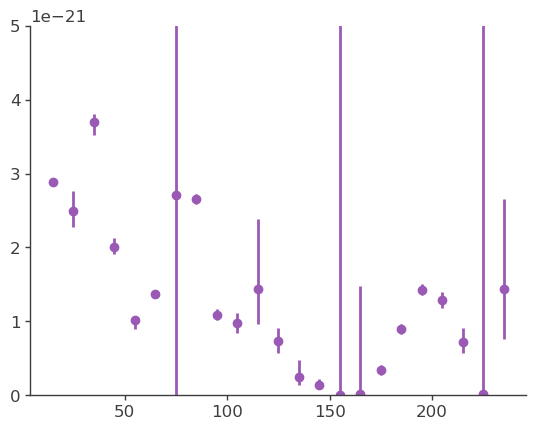

In [89]:
plt.errorbar(gc, dk, [den, dep], fmt="o")
plt.ylim(0,0.5e-20)

(-1.0, -4.0)

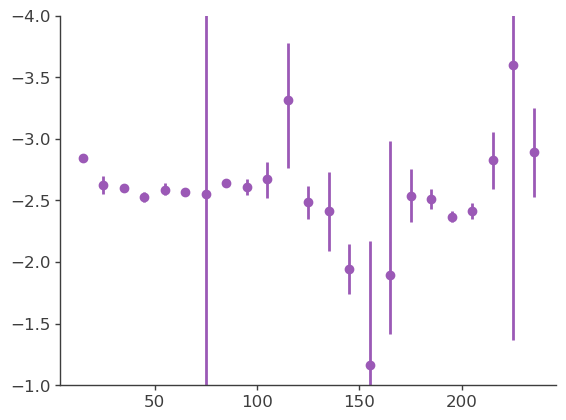

In [90]:
plt.errorbar(gc, di, [die, diep], fmt="o")
plt.ylim(-1,-4)